Title : Robust yield prediction of various farm processing units

Description : A new fast food chain is seeing rapid expansion over the past couple of years. They
              are now trying to optimize their supply chain to ensure that there are no shortages
              of ingredients. For this, they’ve tasked their data science team to come up with a
              model that could predict the output of each food processing farm over the next
              few years. These predictions could further increase the efficiency of their current
              supply chain management systems.

Objectives : 
        1. Explore the data and engineer new features
        2. Predict the yield for each farm during the given timestamps
        3. Given the forecasted demand for the next few months for a particular ingredient, device a strategy to source it

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import the libraries neeeded

In [0]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
sns.set_palette("GnBu_d")
sns.set_style('whitegrid')
import pandas_profiling as pp

Reading the datasets from the drive mounted

In [0]:
train_data=pd.read_csv("/content/drive/My Drive/train_data.csv")
farm_data=pd.read_csv("/content/drive/My Drive/farm_data.csv")
train_weather=pd.read_csv("/content/drive/My Drive/train_weather.csv")

In [0]:
print(train_data.shape)
print(farm_data.shape)
print(train_weather.shape)

(20216100, 4)
(1449, 6)
(139773, 9)


In [0]:
train_data.head(5)

,date,farm_id,ingredient_type,yield
0,2016-01-01 00:00:00,fid_110884,ing_w,0.0
1,2016-01-01 00:00:00,fid_90053,ing_w,0.0
2,2016-01-01 00:00:00,fid_17537,ing_w,0.0
3,2016-01-01 00:00:00,fid_110392,ing_w,0.0
4,2016-01-01 00:00:00,fid_62402,ing_w,0.0


In [0]:
farm_data.head(5)

,farm_id,operations_commencing_year,num_processing_plants,farm_area,farming_company,deidentified_location
0,fid_110884,2008.0,NaN,690.455096,Obery Farms,location 7369
1,fid_90053,2004.0,NaN,252.696160,Obery Farms,location 7369
2,fid_17537,1991.0,NaN,499.446528,Obery Farms,location 7369
3,fid_110392,2002.0,NaN,2200.407555,Obery Farms,location 7369
4,fid_62402,1975.0,NaN,10833.140121,Obery Farms,location 7369


In [0]:
train_weather.head(5)

,timestamp,deidentified_location,temp_obs,cloudiness,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed
0,2016-01-01 00:00:00,location 7369,25.0,6.0,0.0,20.0,1019.7,NaN,0.0
1,2016-01-01 01:00:00,location 7369,24.4,NaN,70.0,21.1,1020.2,-1.0,1.5
2,2016-01-01 02:00:00,location 7369,22.8,2.0,0.0,21.1,1020.2,0.0,0.0
3,2016-01-01 03:00:00,location 7369,21.1,2.0,0.0,20.6,1020.1,0.0,0.0
4,2016-01-01 04:00:00,location 7369,20.0,2.0,250.0,20.0,1020.0,-1.0,2.6


In [0]:
pp.ProfileReport(train_data)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,4
Number of observations,20216100
Total Missing (%),0.0%
Total size in memory,616.9 MiB
Average record size in memory,32.0 B
Numeric,1
Categorical,3
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [0]:
pp.ProfileReport(farm_data)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,6
Number of observations,1449
Total Missing (%),21.5%
Total size in memory,68.0 KiB
Average record size in memory,48.1 B
Numeric,3
Categorical,3
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [0]:
pp.ProfileReport(train_weather)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,9
Number of observations,139773
Total Missing (%),10.9%
Total size in memory,9.6 MiB
Average record size in memory,72.0 B
Numeric,7
Categorical,2
Boolean,0
Date,0
Text (Unique),0
Rejected,0


Unique levels, dtypes of all the colmns in the datsets

In [0]:
def unique(data):
    return(pd.DataFrame({'dtypes':data.dtypes,
                        'column name':data.columns,
                        'null values':data.isnull().sum(),
                         'unique values':data.nunique(),
                         'levels':[data[x].unique() for x in data.columns]
                        }))

In [0]:
unique(train_data)

,dtypes,column name,null values,unique values,levels
date,object,date,0,8784,"[2016-01-01 00:00:00, 2016-01-01 01:00:00, 201..."
farm_id,object,farm_id,0,1434,"[fid_110884, fid_90053, fid_17537, fid_110392,..."
ingredient_type,object,ingredient_type,0,4,"[ing_w, ing_z, ing_x, ing_y]"
yield,float64,yield,0,1688175,"[0.0, 53.2397, 43.0013, 52.4206, 23.3036, 0.37..."


In [0]:
unique(farm_data)

,dtypes,column name,null values,unique values,levels
farm_id,object,farm_id,0,1434,"[fid_110884, fid_90053, fid_17537, fid_110392,..."
operations_commencing_year,float64,operations_commencing_year,774,116,"[2008.0, 2004.0, 1991.0, 2002.0, 1975.0, 2000...."
num_processing_plants,float64,num_processing_plants,1094,18,"[nan, 9.0, 8.0, 14.0, 10.0, 12.0, 11.0, 13.0, ..."
farm_area,float64,farm_area,0,1397,"[690.455096, 252.69616000000002, 499.446528, 2..."
farming_company,object,farming_company,0,16,"[Obery Farms, Dole Food Company, Wayne Farms, ..."
deidentified_location,object,deidentified_location,0,16,"[location 7369, location 959, location 5489, l..."


In [0]:
unique(train_weather)

,dtypes,column name,null values,unique values,levels
timestamp,object,timestamp,0,8784,"[2016-01-01 00:00:00, 2016-01-01 01:00:00, 201..."
deidentified_location,object,deidentified_location,0,16,"[location 7369, location 959, location 5489, l..."
temp_obs,float64,temp_obs,55,619,"[25.0, 24.4, 22.8, 21.1, 20.0, 19.4, 20.6, 18...."
cloudiness,float64,cloudiness,69173,10,"[6.0, nan, 2.0, 4.0, 8.0, 0.0, 9.0, 7.0, 5.0, ..."
wind_direction,float64,wind_direction,6268,43,"[0.0, 70.0, 250.0, 210.0, 290.0, 230.0, 200.0,..."
dew_temp,float64,dew_temp,113,522,"[20.0, 21.1, 20.6, 19.4, 18.9, 18.3, 17.8, 17...."
pressure_sea_level,float64,pressure_sea_level,10618,709,"[1019.7, 1020.2, 1020.1, 1020.0, nan, 1019.4, ..."
precipitation,float64,precipitation,50289,128,"[nan, -1.0, 0.0, 3.0, 5.0, 8.0, 2.0, 10.0, 20...."
wind_speed,float64,wind_speed,304,58,"[0.0, 1.5, 2.6, 3.1, 4.1, 3.6, 5.1, 4.6, 2.1, ..."


##missing values in columns

In [0]:
#function for missing values in columns
def missing_coldata(df):
    missin_col = pd.DataFrame(round(df.isnull().sum().sort_values(ascending=False)/len(df.index)*100,1), 
                              columns=['% of missing value'])
    missin_col['Count of Missing Values'] = df.isnull().sum()
    return missin_col

In [0]:
print(missing_coldata(train_data))
print(missing_coldata(farm_data))
print(missing_coldata(train_weather))

                 % of missing value  Count of Missing Values
yield                           0.0                        0
ingredient_type                 0.0                        0
farm_id                         0.0                        0
date                            0.0                        0
                            % of missing value  Count of Missing Values
num_processing_plants                     75.5                     1094
operations_commencing_year                53.4                      774
deidentified_location                      0.0                        0
farming_company                            0.0                        0
farm_area                                  0.0                        0
farm_id                                    0.0                        0
                       % of missing value  Count of Missing Values
cloudiness                           49.5                    69173
precipitation                        36.0                

Dropping the columns which are having 50% and more



In [0]:
#train_weather
train_weather.drop(["cloudiness"],axis=1,inplace=True)

#farm_data
farm_data.drop(["num_processing_plants","operations_commencing_year"],axis=1,inplace=True)

Dropping the rows which are having Duplicates

In [0]:
#train_data
#train_data.drop_duplicates(subset=["date","farm_id","ingredient_type"],inplace=True)

#farm_data
farm_data.drop_duplicates(subset=["farm_id"],inplace=True)



In [0]:
train_data.shape

(20216100, 4)

In [0]:
farm_data.shape

(1434, 4)

In [0]:
farm_data.columns

Index(['farm_id', 'farm_area', 'farming_company', 'deidentified_location'], dtype='object')

In [0]:
train_weather.columns

Index(['timestamp', 'deidentified_location', 'temp_obs', 'wind_direction',
       'dew_temp', 'pressure_sea_level', 'precipitation', 'wind_speed'],
      dtype='object')

##merging the datasets 

In [0]:
merge_temp = pd.merge(train_data,farm_data,on="farm_id")

In [33]:
merge_temp.shape

(20216100, 7)

In [0]:
train_merge=pd.merge(merge_temp,train_weather,how="left",left_on=["deidentified_location","date"],right_on=["deidentified_location","timestamp"])

In [35]:
train_merge.shape

(20216100, 14)

In [0]:
train_merge.drop(["timestamp"],axis=1,inplace=True)

##Visualization

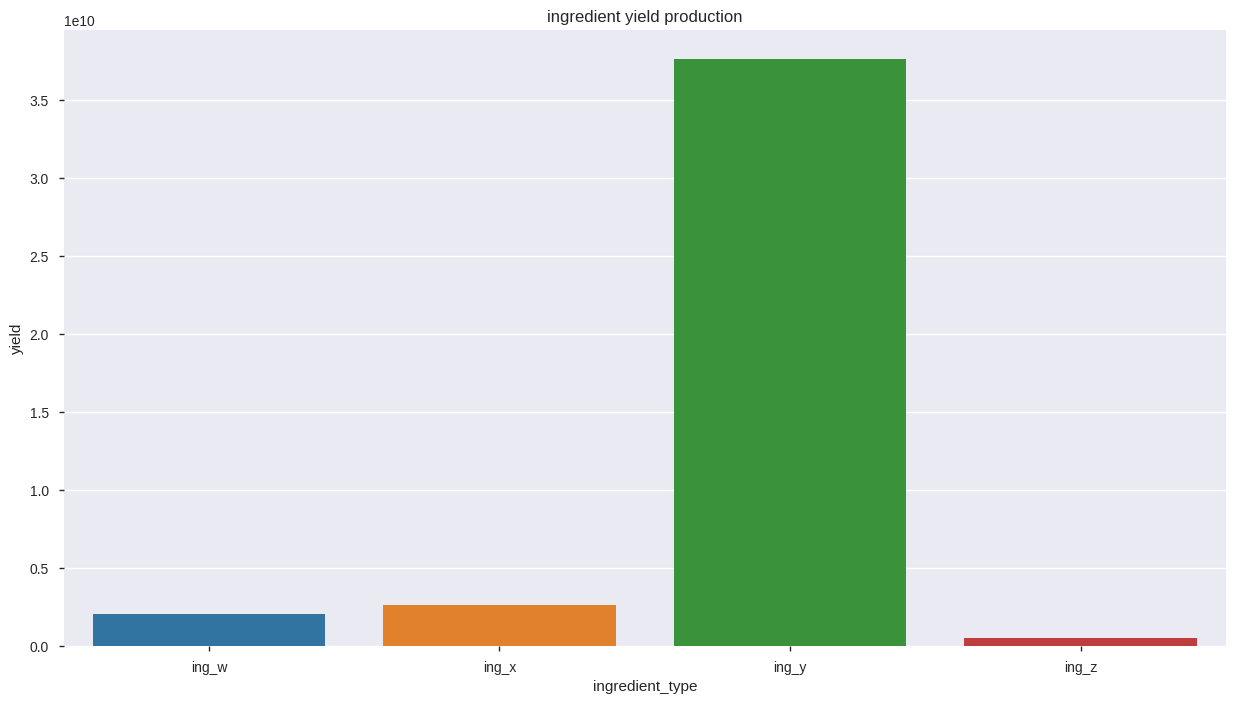

In [0]:
ing_yeild=pd.DataFrame(train_merge.groupby("ingredient_type")["yield"].sum())
ing_yeild=ing_yeild.reset_index()
plt.figure(figsize=(15,8))
sns.barplot(x="ingredient_type",y="yield",data=ing_yeild)
plt.title("ingredient yield production")
plt.show()

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  fig.canvas.print_figure(bytes_io, **kw)


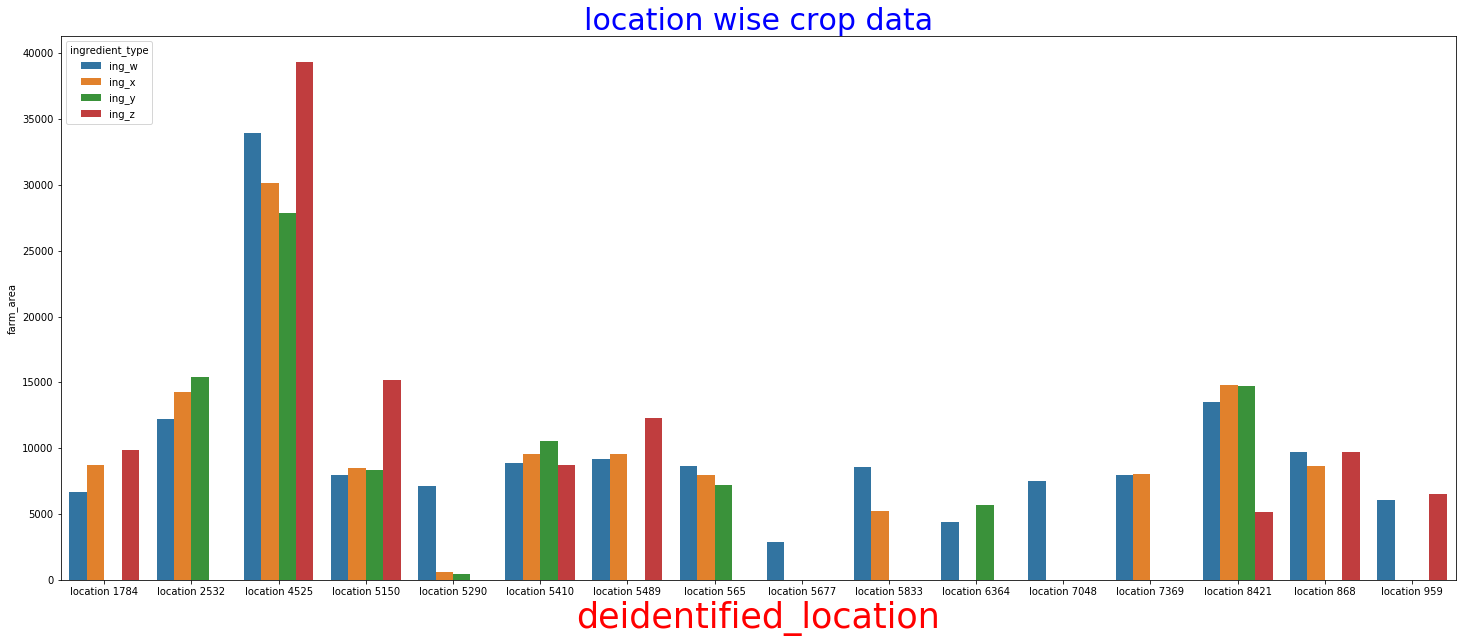

In [0]:
farmarea=pd.DataFrame(train_merge.groupby(["ingredient_type","deidentified_location"])["farm_area"].mean())
farmarea=farmarea.reset_index()
plt.figure(figsize=(25,10))
sns.barplot(x="deidentified_location",y="farm_area",data=farmarea,hue="ingredient_type",)
plt.title("location wise crop data",fontsize=30,color = 'B')
plt.xlabel("deidentified_location",fontsize=35,color = 'r')
plt.show()

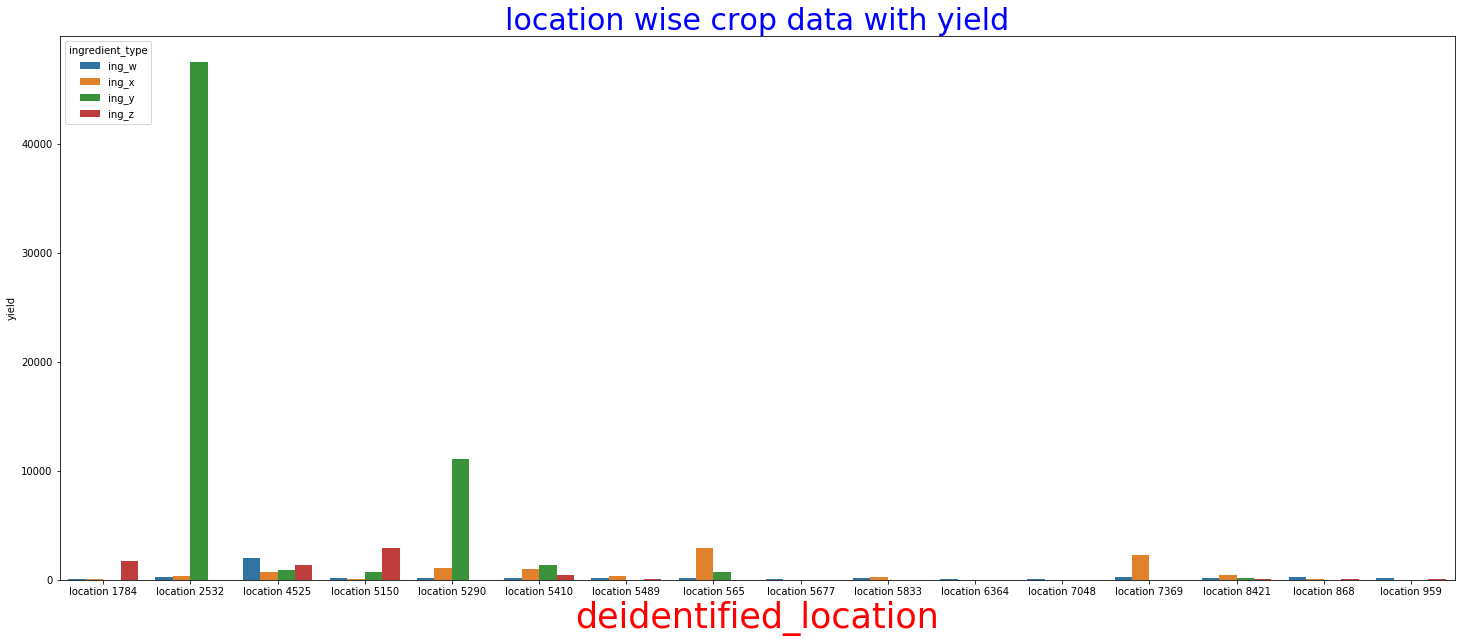

In [0]:
farmarea=pd.DataFrame(train_merge.groupby(["ingredient_type","deidentified_location"])["yield"].mean())
farmarea=farmarea.reset_index()
plt.figure(figsize=(25,10))
sns.barplot(x="deidentified_location",y="yield",data=farmarea,hue="ingredient_type",)
plt.title("location wise crop data with yield",fontsize=30,color = 'B')
plt.xlabel("deidentified_location",fontsize=35,color = 'r')
plt.show()

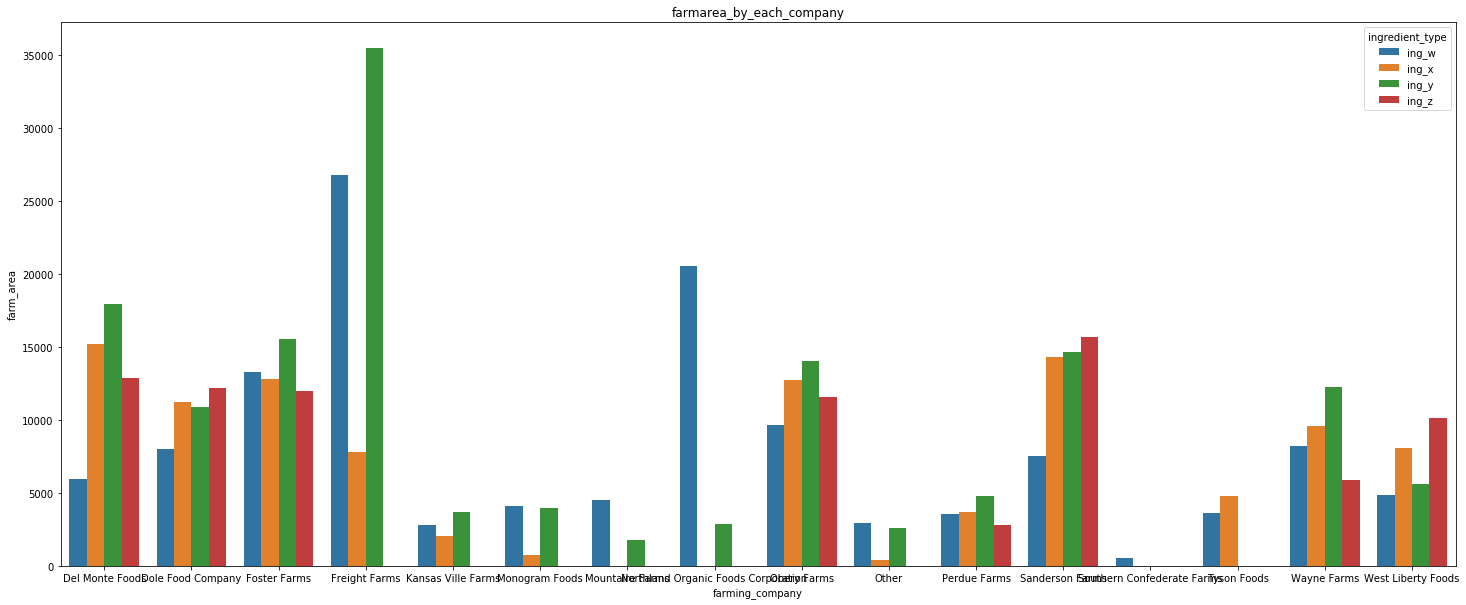

In [0]:
farmarea_by_each_company=pd.DataFrame(train_merge.groupby(["ingredient_type","farming_company"])["farm_area"].mean())
farmarea_by_each_company=farmarea_by_each_company.reset_index()
plt.figure(figsize=(25,10))
sns.barplot(x="farming_company",y="farm_area",data=farmarea_by_each_company,hue="ingredient_type",saturation=0.75)
plt.title("farmarea_by_each_company")
plt.show()

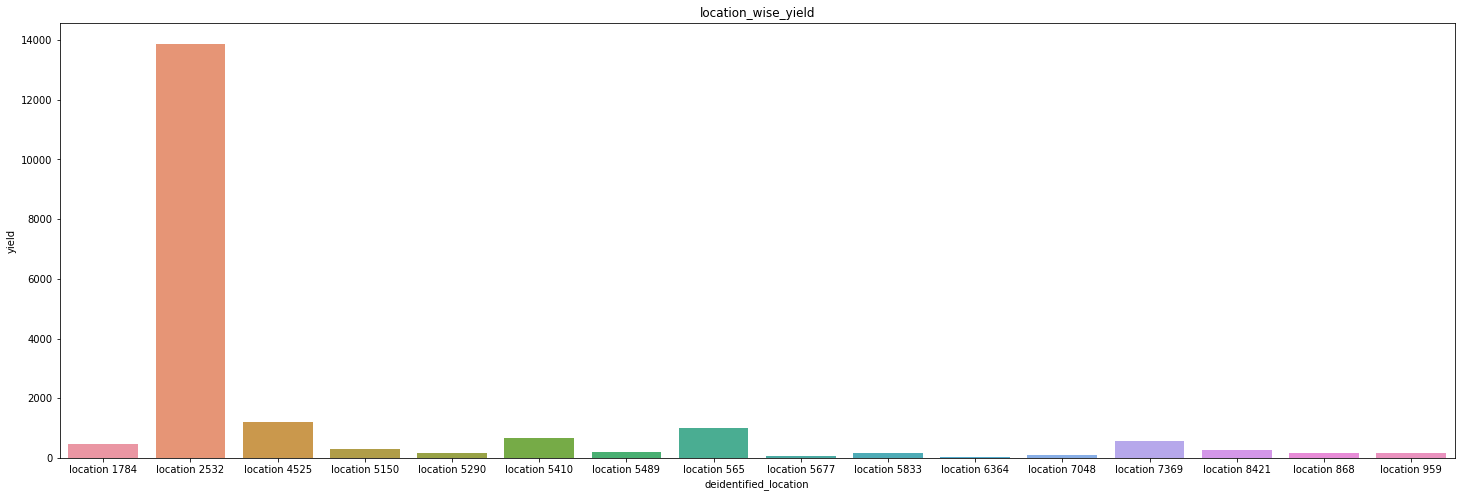

In [0]:
locationwise_yield=pd.DataFrame(train_merge.groupby("deidentified_location")["yield"].mean())
locationwise_yield=locationwise_yield.reset_index()
plt.figure(figsize=(25,8))
sns.barplot(x="deidentified_location",y="yield",data=locationwise_yield)
plt.title("location_wise_yield")
plt.show()

Text(0, 0.5, 'yield')

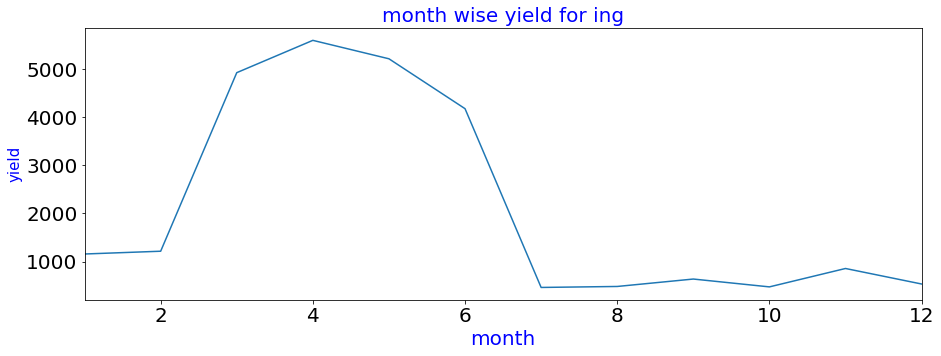

In [0]:
temp=train_merge.groupby(['month'])['yield'].mean()
temp.plot(figsize=(15,5), title= 'month wise yield for ing', fontsize=20)
plt.title('month wise yield for ing',fontsize=20,color = 'B')
plt.xlabel("month",fontsize=20,color = 'B')
plt.ylabel("yield",fontsize=15,color = 'B')

Text(0, 0.5, 'yield')

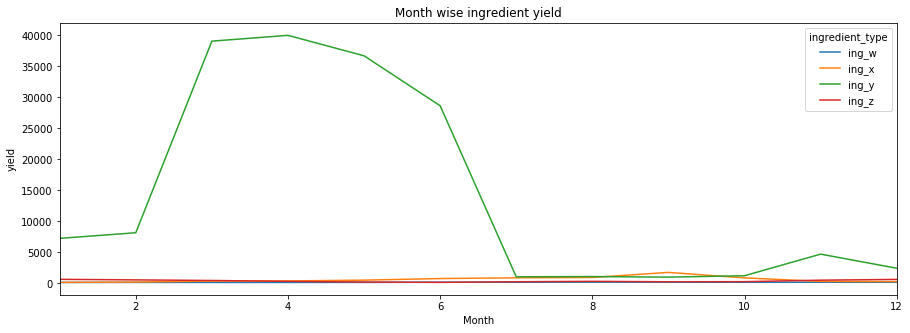

In [0]:
fig, ax = plt.subplots(figsize=(15,5))
train_merge.groupby(['month','ingredient_type']).mean()['yield'].unstack().plot(ax=ax)
# Add title and axis names
plt.title('Month wise ingredient yield')
plt.xlabel("Month")
plt.ylabel("yield")

Text(0, 0.5, 'dew_temp(°C)')

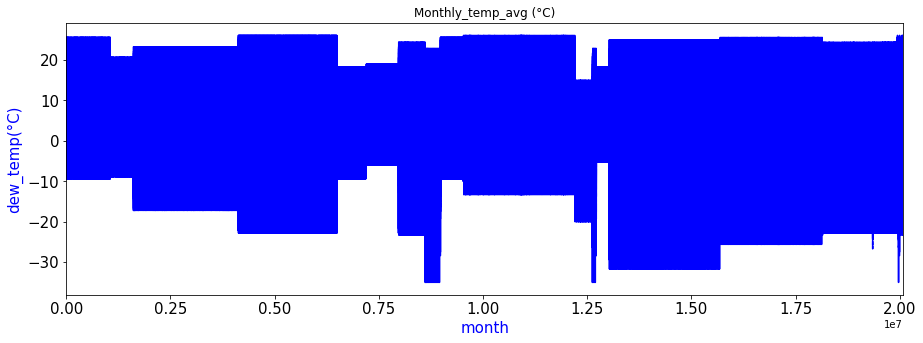

In [0]:
tempr=train_merge.groupby(['month'])['dew_temp']
tempr.plot(figsize=(15,5), title= 'Monthly_temp_avg (°C)', fontsize=15,color = 'B')
plt.xlabel("month",fontsize=15,color = 'B')
plt.ylabel("dew_temp(°C)",fontsize=15,color = 'B')

Text(0.5, 0, 'yield')

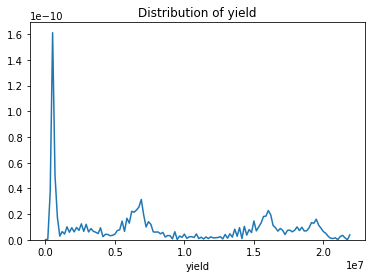

In [0]:
sns.kdeplot(train_merge['yield'].values).set_title("Distribution of yield")
plt.xlabel('yield')

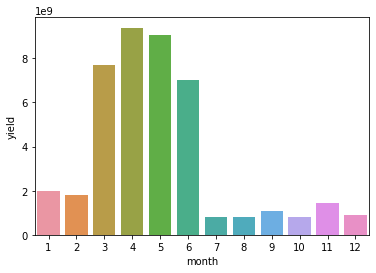

In [0]:
monthsyield=pd.DataFrame(train_merge.groupby("month")["yield"].sum())
monthsyield=monthsyield.reset_index()
sns.barplot(x="month", y="yield", data=monthsyield)


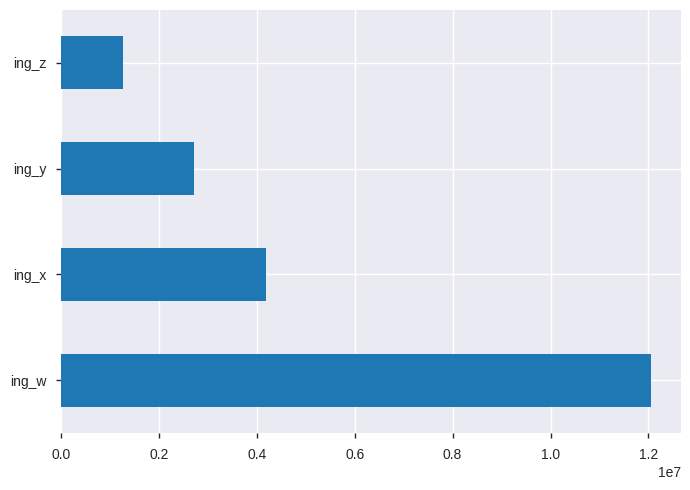

In [0]:
train_merge.ingredient_type.value_counts().plot(kind='barh')

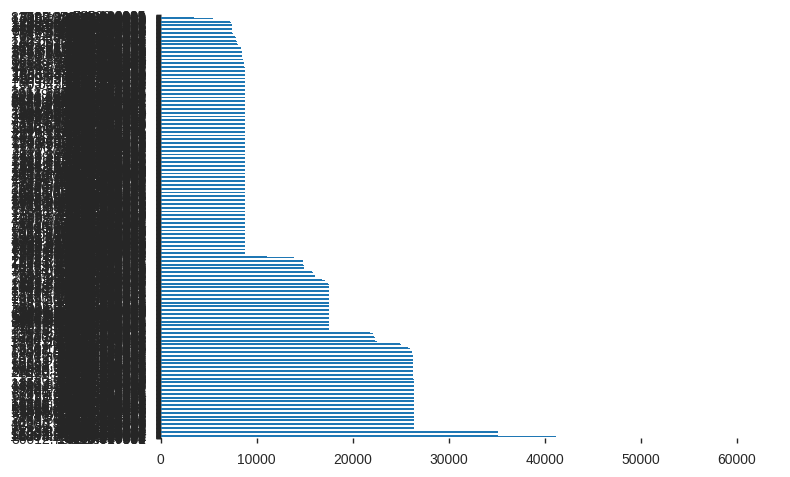

In [0]:
train_merge.farm_area.value_counts().plot(kind='barh')

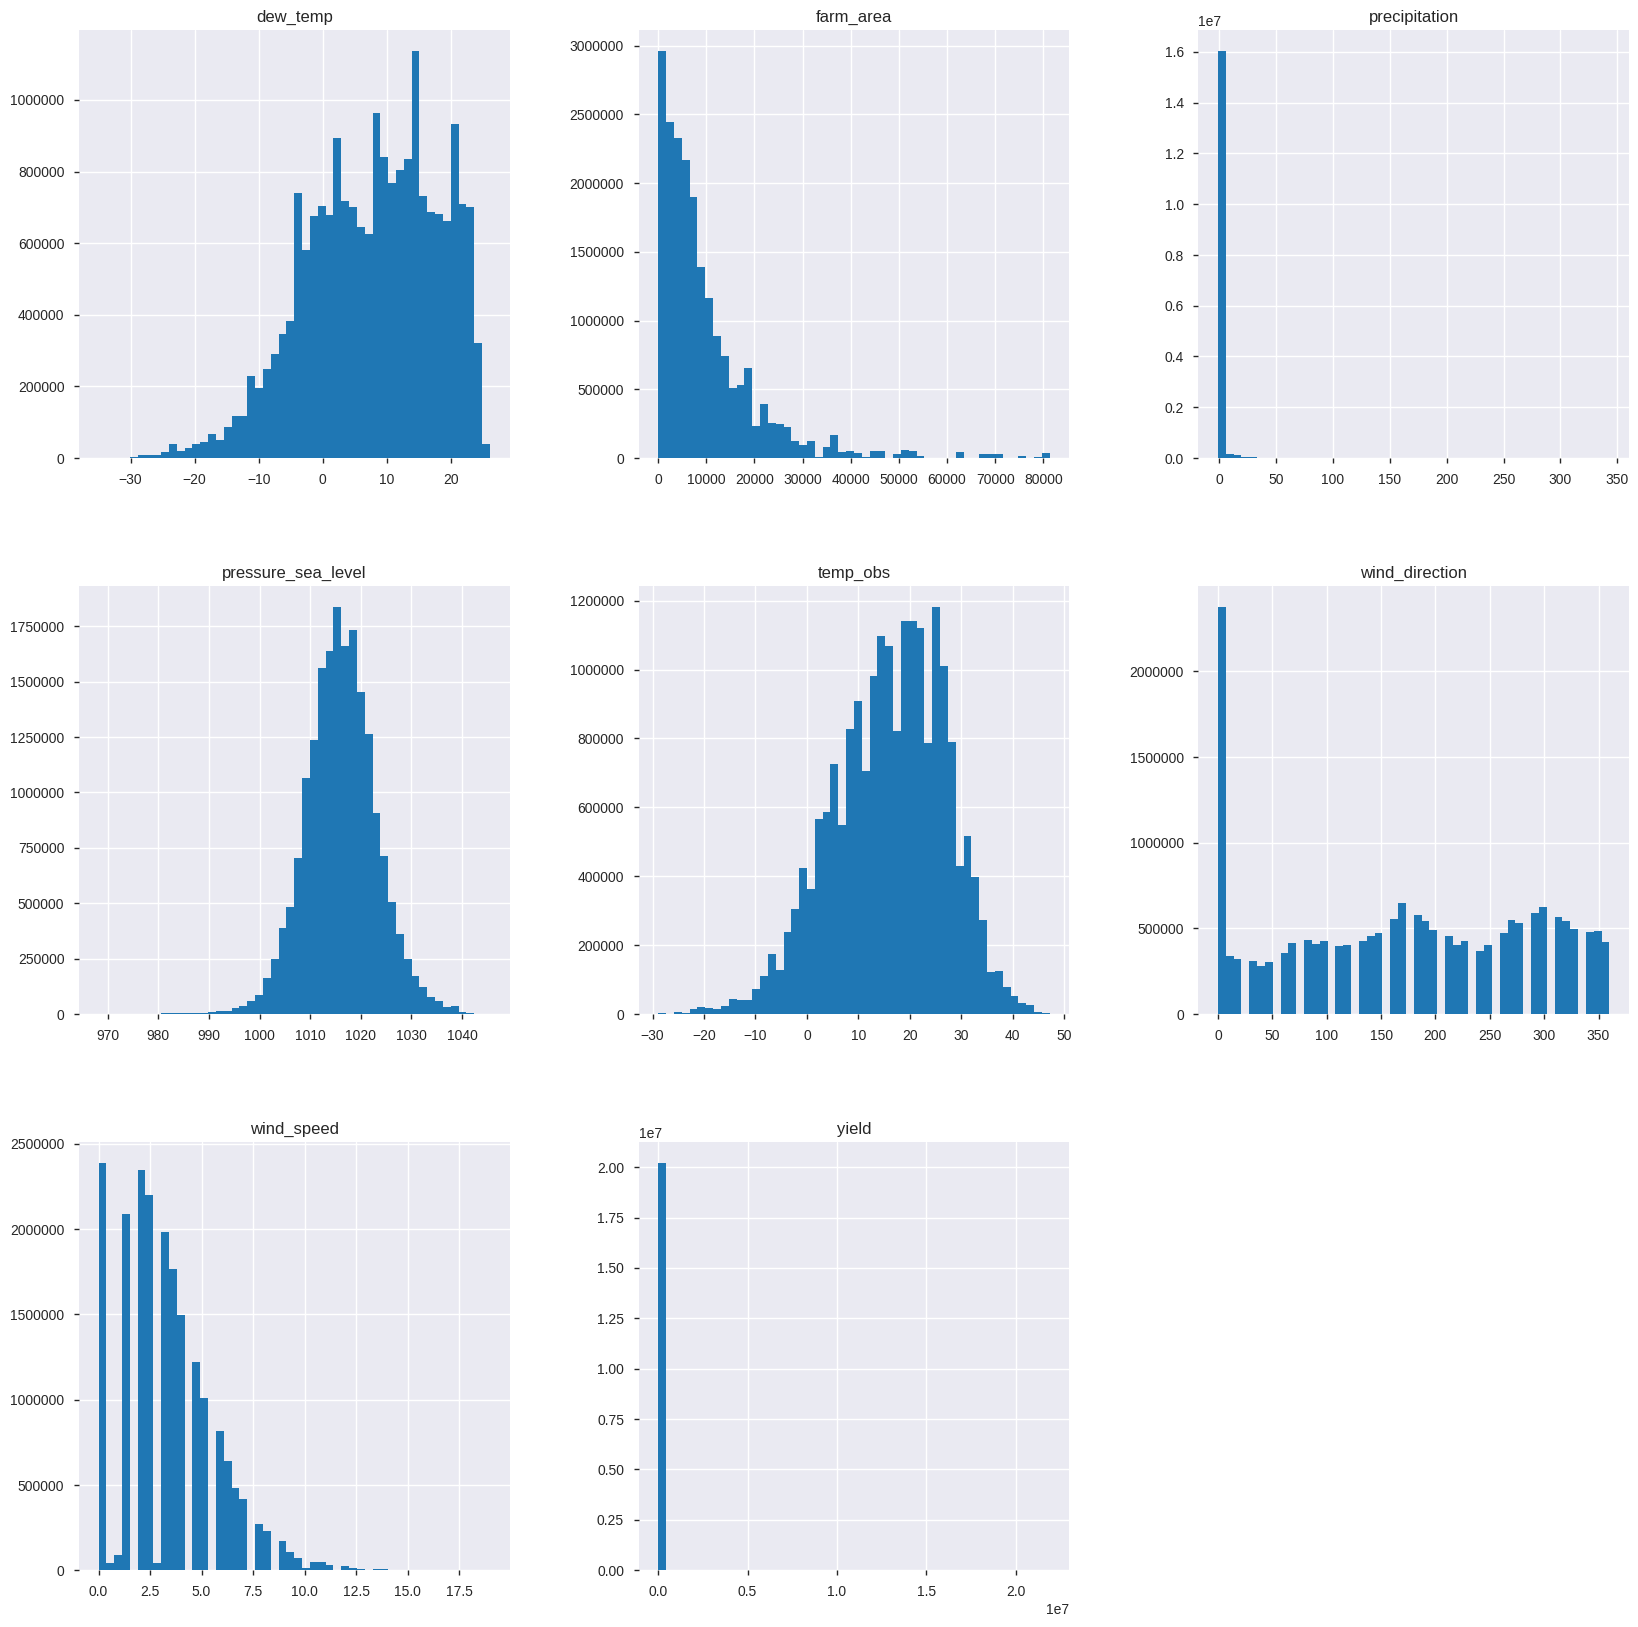

In [0]:
# frequency distribution of the numerical data
train_merge.hist(bins=50, figsize=(20,20))
plt.show()

Distribution of nulls

In [0]:
import missingno as msno

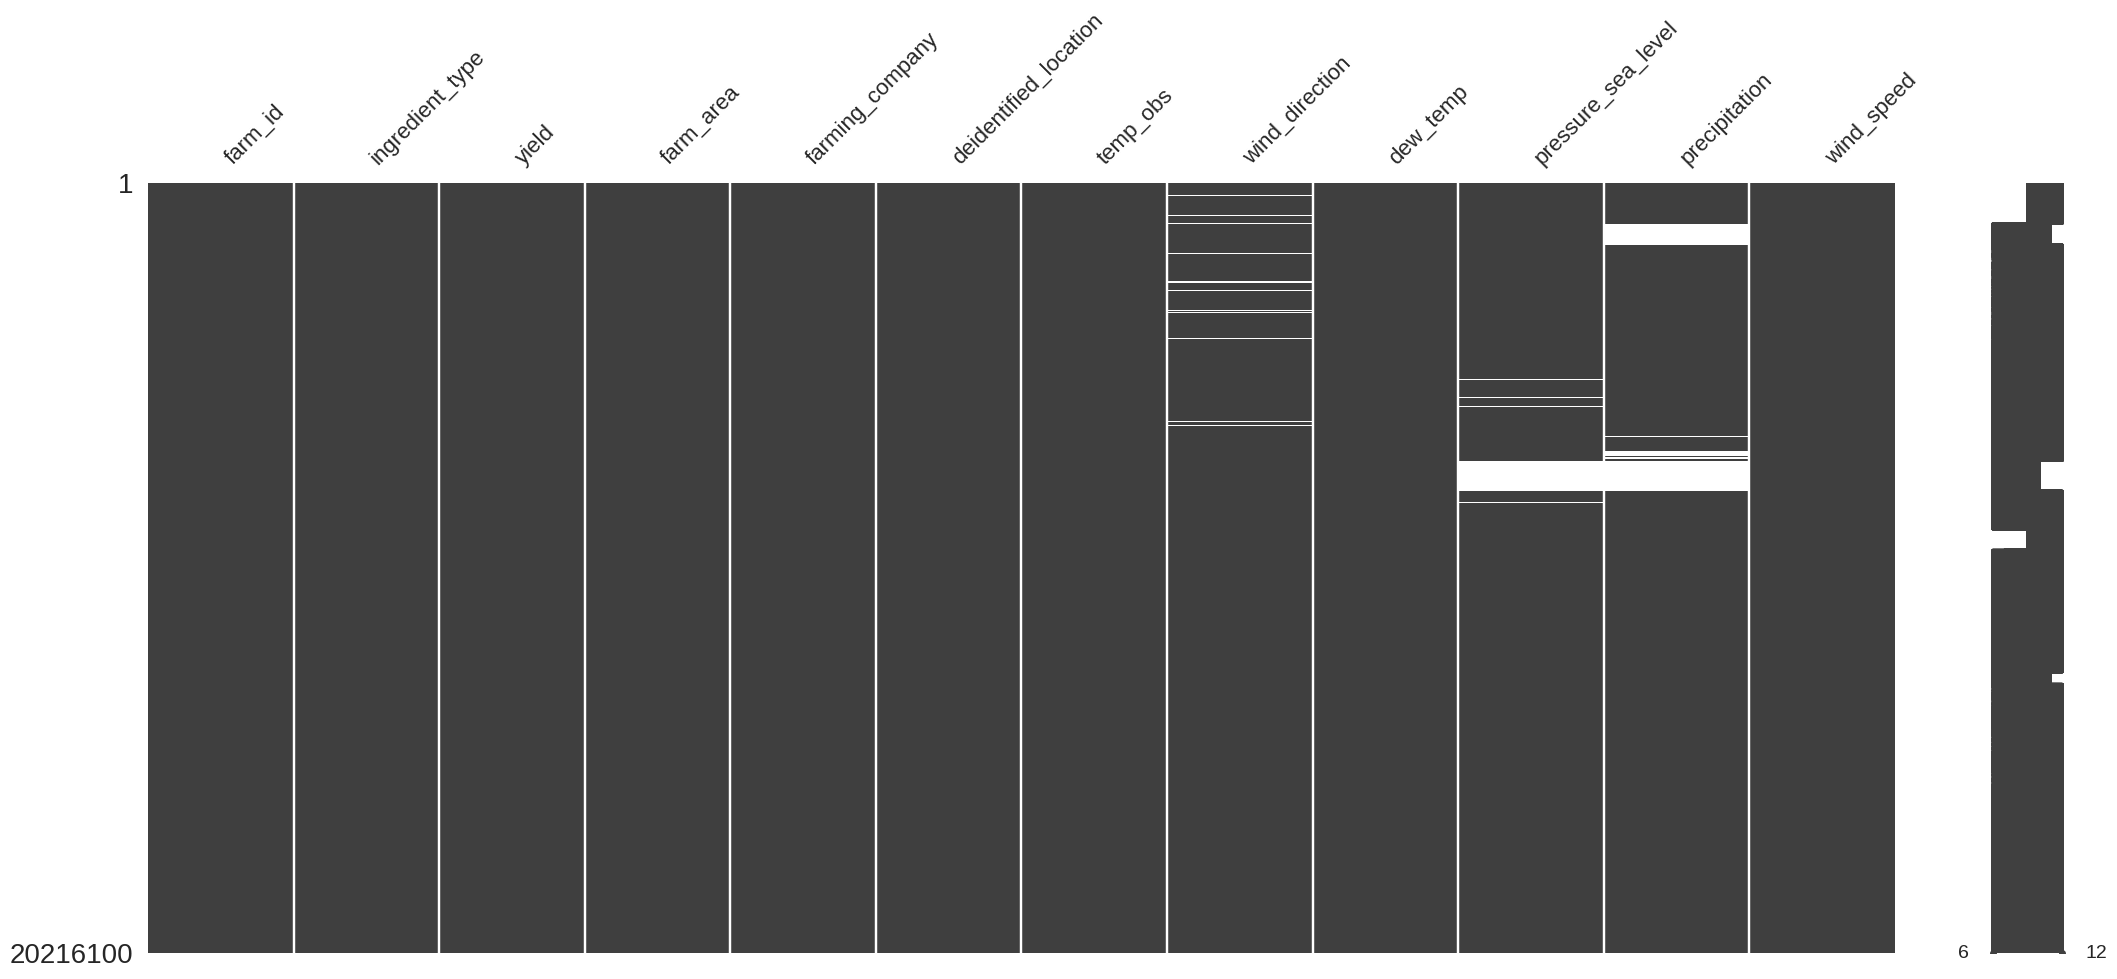

In [0]:
msno.matrix(train_merge)

In [0]:
pip install xlrd

In [0]:
pip install autoviz

In [0]:
from autoviz.AutoViz_Class import AutoViz_Class
AV = AutoViz_Class()

In [0]:
sep = ','
dft = AV.AutoViz(filename="",sep=sep, depVar='yield', dfte=train_merge, header=0, verbose=2, 
                 lowess=False, chart_format='svg', max_rows_analyzed=20216100, max_cols_analyzed=15)

Error in callback <function flush_figures at 0x7f9bae92a7b8> (for post_execute):


KeyboardInterrupt: ignored

In [0]:
train_merge["day"]=pd.DatetimeIndex(train_merge["date"]).day
train_merge["month"]=pd.DatetimeIndex(train_merge["date"]).month
train_merge["hour"]=pd.DatetimeIndex(train_merge["date"]).hour

In [0]:
seasons = ["late_winter", "spring", "summer", "monsoon","autumn","early_winter"]

In [0]:
train_merge['season'] = pd.qcut(train_merge['month'],
                              q = 6,
                              labels=seasons)

In [0]:
season_yield=pd.DataFrame(train_merge.groupby("season")["yield"].sum())
season_yield=season_yield.reset_index()
sns.barplot(x="season", y="yield", data=season_yield)

In [0]:
train_merge.drop(['date'], axis = 1, inplace = True)

Checking data types and converting them to desired dtypes

In [0]:
train_merge.dtypes

farm_id                   object
ingredient_type           object
yield                    float64
farm_area                float64
farming_company           object
deidentified_location     object
temp_obs                 float64
wind_direction           float64
dew_temp                 float64
pressure_sea_level       float64
precipitation            float64
wind_speed               float64
day                        int64
month                      int64
hour                       int64
dtype: object

In [0]:
catagorical = ['farm_id', 'ingredient_type','farming_company', 'deidentified_location']

In [0]:
numerical = train_merge.columns.difference(catagorical)

In [0]:
numerical

Index(['day', 'dew_temp', 'farm_area', 'hour', 'month', 'precipitation',
       'pressure_sea_level', 'temp_obs', 'timestamp', 'wind_direction',
       'wind_speed', 'yield'],
      dtype='object')

In [0]:
train_merge[catagorical] = train_merge[catagorical].apply(lambda x:x.astype("category"))
train_merge[numerical] = train_merge[numerical].apply(lambda x:x.astype("float"))

In [0]:
train_merge.dtypes

farm_id                  category
ingredient_type          category
yield                     float64
farm_area                 float64
farming_company          category
deidentified_location    category
temp_obs                  float64
wind_direction            float64
dew_temp                  float64
pressure_sea_level        float64
precipitation             float64
wind_speed                float64
day                       float64
month                     float64
hour                      float64
dtype: object

Imputing the nulls in our data

In [0]:
train_merge.isnull().sum()

farm_id                        0
ingredient_type                0
yield                          0
farm_area                      0
farming_company                0
deidentified_location          0
temp_obs                   95574
wind_direction           1454415
dew_temp                   99066
pressure_sea_level       1235209
precipitation            3722952
wind_speed                142702
day                            0
month                          0
hour                           0
dtype: int64

In [0]:
num_col=['temp_obs', 'wind_direction', 'dew_temp',
       'pressure_sea_level', 'precipitation', 'wind_speed']

In [0]:
train_merge[num_col] = train_merge[num_col].interpolate(method="linear",limit_direction="both")

In [0]:
train_merge.isnull().sum()

farm_id                  0
ingredient_type          0
yield                    0
farm_area                0
farming_company          0
deidentified_location    0
temp_obs                 0
wind_direction           0
dew_temp                 0
pressure_sea_level       0
precipitation            0
wind_speed               0
day                      0
month                    0
hour                     0
dtype: int64

Saving pre-processed train data for further reference

In [0]:
train_merge.to_csv('/content/drive/My Drive/train_merge.csv',index=False)

Reading test data and performing the same pre-processing steps like that of train data

In [0]:
test_data=pd.read_csv("/content/drive/My Drive/test_data (1).csv")
test_weather=pd.read_csv("/content/drive/My Drive/test_weather (1).csv")
farm_data=pd.read_csv("/content/drive/My Drive/farm_data.csv")

Listing out the unique elements grouped on deidentified location

In [0]:
test_weather.groupby(["deidentified_location"])["timestamp"].nunique()

deidentified_location
location 1784    8743
location 2532    8759
location 4525    8246
location 5150    8520
location 5290    8759
location 5410    8759
location 5489    8760
location 565     8757
location 5677    8760
location 5833    8759
location 6364    8745
location 7048    8750
location 7369    8760
location 8421    8749
location 868     8246
location 959     8753
Name: timestamp, dtype: int64

Distribution of nulls

In [0]:
missing_coldata(test_weather)

,% of missing value,Count of Missing Values
cloudiness,49.7,69065
precipitation,34.4,47788
pressure_sea_level,7.8,10883
wind_direction,4.4,6134
wind_speed,0.2,240
dew_temp,0.1,184
temp_obs,0.0,43
deidentified_location,0.0,0
timestamp,0.0,0


In [0]:
test_weather.drop(["cloudiness"],axis=1,inplace=True)
farm_data.drop(["num_processing_plants","operations_commencing_year"],axis=1,inplace=True)

In [0]:
farm_data.drop_duplicates(subset=["farm_id"],inplace=True)

In [0]:
temp_data2=pd.merge(test_data,farm_data,on="farm_id")

In [0]:
test_merge=pd.merge(temp_data2,test_weather,how="left",left_on=["deidentified_location","date"],
                right_on=["deidentified_location","timestamp"])

In [0]:
test_merge["day"]=pd.DatetimeIndex(test_merge["date"]).day
test_merge["month"]=pd.DatetimeIndex(test_merge["date"]).month
test_merge["hour"]=pd.DatetimeIndex(test_merge["date"]).hour

In [0]:
test_merge.columns

Index(['date', 'farm_id', 'ingredient_type', 'id', 'farm_area',
       'farming_company', 'deidentified_location', 'timestamp', 'temp_obs',
       'cloudiness', 'wind_direction', 'dew_temp', 'pressure_sea_level',
       'precipitation', 'wind_speed', 'day', 'month', 'hour'],
      dtype='object')

In [0]:
test_merge.drop(['date','timestamp'], axis = 1, inplace = True)

In [0]:
test_merge[num_col] = test_merge[num_col].interpolate(method="linear",limit_direction="both")

In [0]:
test_merge.dtypes

farm_id                   object
ingredient_type           object
id                         int64
farm_area                float64
farming_company           object
deidentified_location     object
temp_obs                 float64
cloudiness               float64
wind_direction           float64
dew_temp                 float64
pressure_sea_level       float64
precipitation            float64
wind_speed               float64
day                        int64
month                      int64
hour                       int64
dtype: object

In [0]:
test_merge[catagorical] = test_merge[catagorical].apply(lambda x:x.astype("category"))

In [0]:
numbers = ['day','month','hour']

In [0]:
test_merge[numbers] = test_merge[numbers].apply(lambda x:x.astype("float"))

In [56]:
test_merge.dtypes

farm_id                  category
ingredient_type          category
id                          int64
farm_area                 float64
farming_company          category
deidentified_location    category
temp_obs                  float64
wind_direction            float64
dew_temp                  float64
pressure_sea_level        float64
precipitation             float64
wind_speed                float64
day                       float64
month                     float64
hour                      float64
dtype: object

In [0]:
test_merge.to_csv('/content/drive/My Drive/test_merge.csv',index=False)

In [0]:
import pandas as pd
train=pd.read_csv("/content/drive/My Drive/train_merge.csv")
test = pd.read_csv('/content/drive/My Drive/test_merge.csv')

In [0]:
train.head(5)

,farm_id,ingredient_type,yield,farm_area,farming_company,deidentified_location,temp_obs,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed,day,month,hour
0,fid_110884,ing_w,0.0,690.455096,Obery Farms,location 7369,25.0,0.0,20.0,1019.7,-1.0,0.0,1.0,1.0,0.0
1,fid_110884,ing_w,0.0,690.455096,Obery Farms,location 7369,24.4,70.0,21.1,1020.2,-1.0,1.5,1.0,1.0,1.0
2,fid_110884,ing_w,0.0,690.455096,Obery Farms,location 7369,22.8,0.0,21.1,1020.2,0.0,0.0,1.0,1.0,2.0
3,fid_110884,ing_w,0.0,690.455096,Obery Farms,location 7369,21.1,0.0,20.6,1020.1,0.0,0.0,1.0,1.0,3.0
4,fid_110884,ing_w,0.0,690.455096,Obery Farms,location 7369,20.0,250.0,20.0,1020.0,-1.0,2.6,1.0,1.0,4.0


In [0]:
test.head(5)

,farm_id,ingredient_type,id,farm_area,farming_company,deidentified_location,temp_obs,cloudiness,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed,day,month,hour
0,fid_110884,ing_w,0,690.455096,Obery Farms,location 7369,17.8,4.0,100.0,11.7,1021.4,0.0,3.6,1.0,1.0,0.0
1,fid_110884,ing_w,129,690.455096,Obery Farms,location 7369,17.8,2.0,130.0,12.8,1022.0,0.0,3.1,1.0,1.0,1.0
2,fid_110884,ing_w,258,690.455096,Obery Farms,location 7369,16.1,0.0,140.0,12.8,1021.9,0.0,3.1,1.0,1.0,2.0
3,fid_110884,ing_w,387,690.455096,Obery Farms,location 7369,17.2,0.0,140.0,13.3,1022.2,0.0,3.1,1.0,1.0,3.0
4,fid_110884,ing_w,516,690.455096,Obery Farms,location 7369,16.7,2.0,130.0,13.3,1022.3,0.0,2.6,1.0,1.0,4.0


In [0]:
train.dtypes

farm_id                   object
ingredient_type           object
yield                    float64
farm_area                float64
farming_company           object
deidentified_location     object
temp_obs                 float64
wind_direction           float64
dew_temp                 float64
pressure_sea_level       float64
precipitation            float64
wind_speed               float64
day                      float64
month                    float64
hour                     float64
dtype: object

In [0]:
cat_cols=['farm_id', 'ingredient_type','farming_company', 'deidentified_location']

In [0]:
num_cols=train.columns.difference(cat_cols)

In [0]:
train[cat_cols]=train[cat_cols].apply(lambda x:x.astype("category"))

In [25]:
test.dtypes

farm_id                   object
ingredient_type           object
id                         int64
farm_area                float64
farming_company           object
deidentified_location     object
temp_obs                 float64
wind_direction           float64
dew_temp                 float64
pressure_sea_level       float64
precipitation            float64
wind_speed               float64
day                      float64
month                    float64
hour                     float64
dtype: object

In [0]:
test[cat_cols]= test[cat_cols].apply(lambda x:x.astype("category"))

##Label encodinng for category columns for both train n test 

In [0]:
from sklearn import preprocessing

In [64]:
label_encoder1 = preprocessing.LabelEncoder()
label_encoder2 = preprocessing.LabelEncoder()
label_encoder3 = preprocessing.LabelEncoder()
# Encode labels in column target.

label_encoder1.fit(train['farming_company'])
label_encoder2.fit(train['deidentified_location'])
label_encoder3.fit(train['farm_id'])

LabelEncoder()

In [0]:
train['farming_company']=label_encoder1.transform(train['farming_company'])
train['deidentified_location'] = label_encoder2.transform(train['deidentified_location'])
train['farm_id'] = label_encoder3.transform(train['farm_id'])

In [0]:
test['farming_company']=label_encoder1.transform(test['farming_company'])
test['deidentified_location'] = label_encoder2.transform(test['deidentified_location'])
test['farm_id'] = label_encoder3.transform(test['farm_id'])

In [0]:
train.head()

,farm_id,ingredient_type,yield,farm_area,farming_company,deidentified_location,temp_obs,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed,day,month,hour
0,142,ing_w,0.0,690.455096,8,12,25.0,0.0,20.0,1019.7,-1.0,0.0,1.0,1.0,0.0
1,142,ing_w,0.0,690.455096,8,12,24.4,70.0,21.1,1020.2,-1.0,1.5,1.0,1.0,1.0
2,142,ing_w,0.0,690.455096,8,12,22.8,0.0,21.1,1020.2,0.0,0.0,1.0,1.0,2.0
3,142,ing_w,0.0,690.455096,8,12,21.1,0.0,20.6,1020.1,0.0,0.0,1.0,1.0,3.0
4,142,ing_w,0.0,690.455096,8,12,20.0,250.0,20.0,1020.0,-1.0,2.6,1.0,1.0,4.0


In [0]:
test.head()

,farm_id,ingredient_type,id,farm_area,farming_company,deidentified_location,temp_obs,cloudiness,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed,day,month,hour
0,142,ing_w,0,690.455096,8,12,17.8,4.0,100.0,11.7,1021.4,0.0,3.6,1.0,1.0,0.0
1,142,ing_w,129,690.455096,8,12,17.8,2.0,130.0,12.8,1022.0,0.0,3.1,1.0,1.0,1.0
2,142,ing_w,258,690.455096,8,12,16.1,0.0,140.0,12.8,1021.9,0.0,3.1,1.0,1.0,2.0
3,142,ing_w,387,690.455096,8,12,17.2,0.0,140.0,13.3,1022.2,0.0,3.1,1.0,1.0,3.0
4,142,ing_w,516,690.455096,8,12,16.7,2.0,130.0,13.3,1022.3,0.0,2.6,1.0,1.0,4.0


In [0]:
train.dtypes

farm_id                     int64
ingredient_type          category
yield                     float64
farm_area                 float64
farming_company             int64
deidentified_location       int64
temp_obs                  float64
wind_direction            float64
dew_temp                  float64
pressure_sea_level        float64
precipitation             float64
wind_speed                float64
day                       float64
month                     float64
hour                      float64
dtype: object

In [0]:
test.dtypes

farm_id                     int64
ingredient_type          category
id                          int64
farm_area                 float64
farming_company             int64
deidentified_location       int64
temp_obs                  float64
wind_direction            float64
dew_temp                  float64
pressure_sea_level        float64
precipitation             float64
wind_speed                float64
day                       float64
month                     float64
hour                      float64
dtype: object

Dummifying 'ingredient_type' column

In [0]:
dummy=["ingredient_type"]

In [0]:
train = pd.get_dummies(train,columns=dummy,drop_first=True)

In [0]:
test = pd.get_dummies(test,columns=dummy,drop_first=True)

In [0]:
train.head()

,farm_id,yield,farm_area,farming_company,deidentified_location,temp_obs,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed,day,month,hour,ingredient_type_ing_x,ingredient_type_ing_y,ingredient_type_ing_z
0,142,0.0,690.455096,8,12,25.0,0.0,20.0,1019.7,-1.0,0.0,1.0,1.0,0.0,0,0,0
1,142,0.0,690.455096,8,12,24.4,70.0,21.1,1020.2,-1.0,1.5,1.0,1.0,1.0,0,0,0
2,142,0.0,690.455096,8,12,22.8,0.0,21.1,1020.2,0.0,0.0,1.0,1.0,2.0,0,0,0
3,142,0.0,690.455096,8,12,21.1,0.0,20.6,1020.1,0.0,0.0,1.0,1.0,3.0,0,0,0
4,142,0.0,690.455096,8,12,20.0,250.0,20.0,1020.0,-1.0,2.6,1.0,1.0,4.0,0,0,0


In [0]:
test.head()

,farm_id,id,farm_area,farming_company,deidentified_location,temp_obs,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed,day,month,hour,ingredient_type_ing_x,ingredient_type_ing_y,ingredient_type_ing_z
0,142,0,690.455096,8,12,17.8,100.0,11.7,1021.4,0.0,3.6,1.0,1.0,0.0,0,0,0
1,142,129,690.455096,8,12,17.8,130.0,12.8,1022.0,0.0,3.1,1.0,1.0,1.0,0,0,0
2,142,258,690.455096,8,12,16.1,140.0,12.8,1021.9,0.0,3.1,1.0,1.0,2.0,0,0,0
3,142,387,690.455096,8,12,17.2,140.0,13.3,1022.2,0.0,3.1,1.0,1.0,3.0,0,0,0
4,142,516,690.455096,8,12,16.7,130.0,13.3,1022.3,0.0,2.6,1.0,1.0,4.0,0,0,0


Shapes of train and test merged dataframes

In [34]:
print("Shape of train data", train.shape)
print("Shape of test data", test.shape)

Shape of train data (20216100, 17)
Shape of test data (20848800, 17)


In [0]:
train.columns

Index(['farm_id', 'farm_area', 'farming_company', 'deidentified_location',
       'temp_obs', 'wind_direction', 'dew_temp', 'pressure_sea_level',
       'precipitation', 'wind_speed', 'day', 'month', 'hour',
       'ingredient_type_ing_x', 'ingredient_type_ing_y',
       'ingredient_type_ing_z'],
      dtype='object')

In [0]:
test.columns

Index(['farm_id', 'id', 'farm_area', 'farming_company',
       'deidentified_location', 'temp_obs', 'wind_direction', 'dew_temp',
       'pressure_sea_level', 'precipitation', 'wind_speed', 'day', 'month',
       'hour', 'ingredient_type_ing_x', 'ingredient_type_ing_y',
       'ingredient_type_ing_z'],
      dtype='object')

##Train_test_split

In [0]:
from sklearn.model_selection import train_test_split
X = train.drop('yield',axis = 1)
y = train['yield']


In [0]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=123)

In [0]:
# function for calculating the rmse and mape
import numpy as np
from sklearn import metrics
def rmse(train_actual,train_prediction,test_actual,test_prediction):
    print('Metrics on train')
    print('RMSE: ',np.sqrt(metrics.mean_squared_error(train_actual, train_prediction)))
    print('Metrics on validation data')
    print('RMSE: ',np.sqrt(metrics.mean_squared_error(train_actual, train_prediction)))


Linear Regression

In [0]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
regressor=LinearRegression()
regressor.fit(X_train,y_train)

y_val_pred = regressor.predict(X_val)
y_train_pred = regressor.predict(X_train)

In [74]:
rmse(y_train,y_train_pred,y_val,y_val_pred)

Metrics on train
RMSE:  153746.26228129613
Metrics on validation data
RMSE:  153746.26228129613


In [0]:
from mlxtend.plotting import plot_learning_curves

In [76]:
plot_learning_curves(X_train, y_train, X_val, y_val, regressor, scoring='mean_squared_error')

([24141615053.503082,
  24937260006.459885,
  24890796030.585426,
  24685964900.671886,
  24378052414.291897,
  24448618139.363873,
  24591942602.56091,
  24247413126.269505,
  23676157015.01915,
  23637913165.469105],
 [22655049244.416187,
  22655130326.195053,
  22655137496.888714,
  22655150240.830452,
  22655131137.56006,
  22655141327.150627,
  22655150761.380196,
  22655093293.045296,
  22655047960.056564,
  22655040167.496483])

Decision Tree

In [26]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()
dt.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [0]:
dt_train_pred = dt.predict(X_train)
dt_val_pred = dt.predict(X_val)

In [28]:
rmse(y_train,dt_train_pred,y_val,dt_val_pred)

Metrics on train
RMSE:  26.170664398688732
Metrics on validation data
RMSE:  26.170664398688732


([2.3335514092903614e-12,
  4.0744271088657525e-12,
  6.01542162343013e-12,
  8.053505525599233e-12,
  9.937872505009013e-12,
  1.158200772488658e-11,
  1.3657589478030699e-11,
  1.5614407569813824e-11,
  1.7545603872599457e-11,
  1.9365498132518485e-11],
 [238492.94483911205,
  162966.28381748995,
  125226.67199530483,
  103409.87954497515,
  87411.25413336407,
  75718.00966774291,
  66767.80465784692,
  59611.00048402376,
  53457.955860203336,
  48590.36822902548])

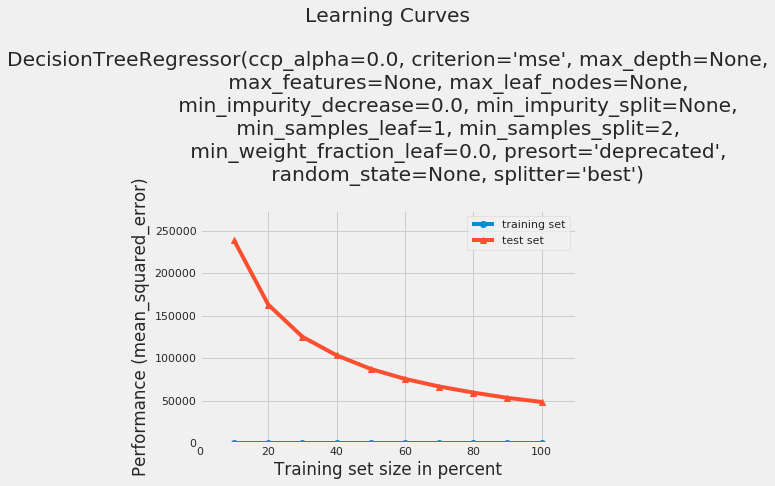

In [0]:
plot_learning_curves(X_train, y_train, X_val, y_val, dt, scoring='mean_squared_error')

In [0]:
from sklearn.tree import DecisionTreeRegressor
dt1 = DecisionTreeRegressor(criterion='mse',splitter='best',max_depth=20,min_samples_split=50,min_samples_leaf=35,random_state=456)
dt1.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=20,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=35, min_samples_split=50,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=456, splitter='best')

In [0]:
dt1_train_pred = dt1.predict(X_train)
dt1_val_pred = dt1.predict(X_val)

In [0]:
rmse(y_train,dt1_train_pred,y_val,dt1_val_pred)

Metrics on train
RMSE:  0.7199562440975045
Metrics on validation data
RMSE:  0.7430237469839174


([324257.79679147067,
  264459.32448859885,
  239104.93611197066,
  223847.16203197016,
  213098.39087830155,
  205980.4329630048,
  200248.29840389165,
  196193.67483830714,
  192631.1516419865,
  189243.34427525144],
 [386789.34348313423,
  310654.2805208088,
  275502.90506914485,
  254634.1215193246,
  240104.0327419643,
  229558.86660246595,
  221695.93046609758,
  215496.22119047516,
  210518.26888195946,
  205979.70188966065])

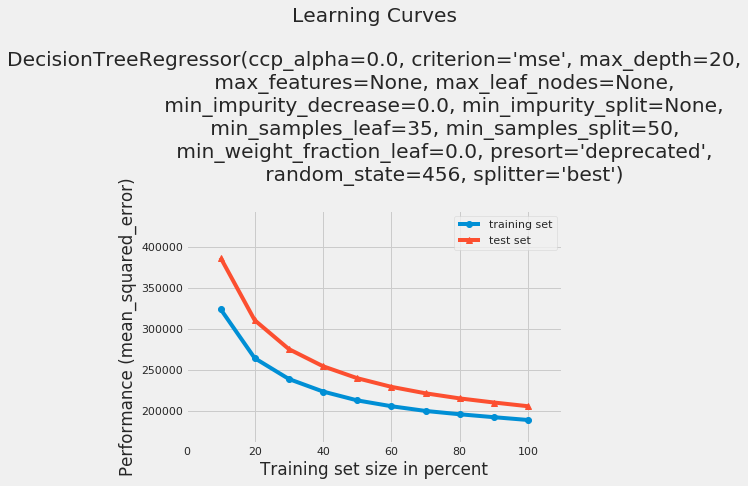

In [0]:
plot_learning_curves(X_train, y_train, X_val, y_val, dt1, scoring='mean_squared_error')

In [0]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=20, random_state=45,min_samples_split=50,min_samples_leaf=20,max_features='auto')
rf.fit(X_train, y_train)


In [0]:
rf_train_pred = rf.predict(X_train)
rf_val_pred = rf.predict(X_val)

In [0]:
rmse(y_train,rf_train_pred,y_val,rf_val_pred)

XG Boost

In [0]:
from xgboost import XGBRegressor
xg = XGBRegressor()

xg.fit(X_train,y_train)

In [0]:
xg_train_pred = xg.predict(X_train)
xg_val_pred = xg.predict(X_val)

In [0]:
rmse(y_train,xg_train_pred,y_val,xg_val_pred)

In [0]:
id = test['id']

In [0]:
test.drop('id', axis = 1, inplace = True)

In [0]:
rf.predict(test)

In [0]:
output = pd.DataFrame({'id':id,'yield':rf.predict(test)})

In [0]:
output.to_csv( 'solution2.csv',index=False)

In [0]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(output["yield"]))
print(z)


[0.23101843 0.2310184  0.23105242 ... 0.21490363 0.21529996 0.21574855]


Removing outliers

In [0]:


z_new = [] 
def remove_outlier(data):
    for i in data.columns:
        z = np.abs(stats.zscore(data[i]))
        z_new = z_new.append(z)



threshold = 1.96


data= data[(z < 1.96)]

In [0]:
%%time

from sklearn.ensemble import RandomForestRegressor

rfr=RandomForestRegressor()
rfr.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [0]:
rmse(y_train,rfr.predict(X_train),y_val,rfr.predict(X_val))

train
rmse:  259.51269916681576
val
rmse:  513.3707605951712


In [0]:
output2=pd.DataFrame({'id':id,'yield':rfr.predict(test)})

In [0]:
output2

,id,yield
0,0,9897.53590
1,129,9897.53590
2,258,9897.53590
3,387,9938.90740
4,516,9364.77913
...,...,...
20848795,41673195,6392.89020
20848796,41673445,6392.89020
20848797,41673695,6392.89020
20848798,41673945,6392.89020


In [0]:
output2.to_csv( '/content/drive/My Drive/solution4.csv',index=False)

In [0]:
sol=pd.read_csv("/content/drive/My Drive/solution4.csv")

In [0]:
sol.shape

(20848800, 2)